In [12]:

# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot

# synthetic classification dataset
from numpy import where
from sklearn.datasets import make_classification
from matplotlib import pyplot

# affinity propagation clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from matplotlib import pyplot

# agglomerative clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot


import pandas as pd 
import numpy as np
from sklearn.preprocessing import FunctionTransformer

## Test dataset used in the example

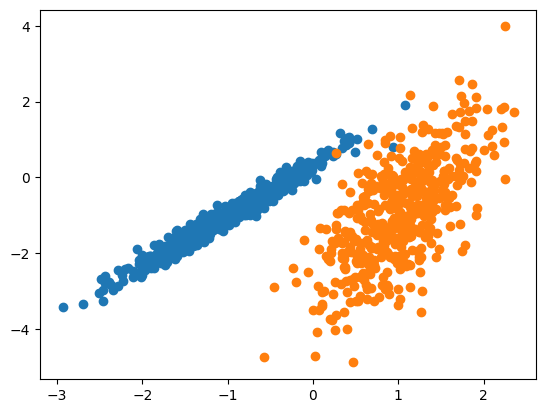

In [2]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# create scatter plot for samples from each class
for class_value in range(2):
 # get row indexes for samples with this class
 row_ix = where(y == class_value)
 # create scatter of these samples
 pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

## Test dataset used by TCGA

## Read and merge dataset with the correct labels 

In [5]:
fpkm_unstr_df_with_labels = pd.read_csv('./Transcriptomics/data/processed_data/fpkm_unstr_data_with_labels.csv')
gene_cols = fpkm_unstr_df_with_labels.columns.to_numpy()[:60660]
exposure_tsv = pd.read_csv('./Transcriptomics/data/clinical.cart.2023-10-29/exposure.tsv', sep='\t')
ge_kidney_cancer_data_with_tgca_labels = pd.merge(fpkm_unstr_df_with_labels,
                                                  exposure_tsv[['case_submitter_id', 'project_id']],
                                                  left_on='Case ID',
                                                  right_on='case_submitter_id')


## Subset the 3 subtypes of cancer for analysis

In [16]:
ge_kidney_cancer_data_correct_labels = (ge_kidney_cancer_data_with_tgca_labels[ge_kidney_cancer_data_with_tgca_labels['project_id']
                                                                               .isin(
    ['TCGA-KIRC', 'TCGA-KICH', 'TCGA-KIRP']
)]
)

## Apply log transform to all the values

In [17]:
transformer = FunctionTransformer(np.log10)
ge_kidney_cancer_data_correct_labels[gene_cols] = ge_kidney_cancer_data_correct_labels[gene_cols] + 1
ge_kidney_cancer_data_correct_labels[gene_cols] = transformer.fit_transform(ge_kidney_cancer_data_correct_labels[gene_cols])

/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ipykernel_25004/19597005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ge_kidney_cancer_data_correct_labels[gene_cols] = ge_kidney_cancer_data_correct_labels[gene_cols] + 1
/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ipykernel_25004/19597005.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ge_kidney_cancer_data_correct_labels[gene_cols] = transformer.fit_transform(ge_kidney_cancer_data_correct_labels[gene_cols])


## Apply Umap to get reduced embeddings

In [21]:
import OmicsUtils.DimRedMappers.umap_embedders
import umap

In [19]:
umap_embed_class = OmicsUtils.DimRedMappers.umap_embedders.umap_embedder(data=ge_kidney_cancer_data_correct_labels[gene_cols])

In [55]:
mapper = umap.UMAP(output_metric='haversine', random_state=42).fit(ge_kidney_cancer_data_correct_labels[gene_cols])
hyperbolic_mapper = umap.UMAP(output_metric='hyperboloid',
                              random_state=42).fit(ge_kidney_cancer_data_correct_labels[gene_cols])
ge_kidney_cancer_data_embedding = umap_embed_class.create_embedded_df(mapper=hyperbolic_mapper)

/opt/homebrew/anaconda3/envs/umap-env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/homebrew/anaconda3/envs/umap-env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [56]:
ge_kidney_cancer_data_embedding['project_id'] = ge_kidney_cancer_data_correct_labels['project_id'].to_numpy()
ge_kidney_cancer_data_embedding['Sample Type'] = ge_kidney_cancer_data_correct_labels['Sample Type'].to_numpy()

In [57]:
ge_kidney_cancer_data_embedding

,embed_x,embed_y,project_id,Sample Type
0,2.976236,4.300343,TCGA-KIRC,Primary Tumor
1,21.695953,-1.710289,TCGA-KIRP,Primary Tumor
2,-16.151369,-6.167317,TCGA-KIRP,Solid Tissue Normal
3,6.548849,-0.294208,TCGA-KIRP,Primary Tumor
4,-1.061437,21.987959,TCGA-KICH,Primary Tumor
...,...,...,...,...
919,17.394644,-1.731792,TCGA-KIRP,Primary Tumor
920,21.602587,-0.025158,TCGA-KIRP,Primary Tumor
921,17.796091,18.525505,TCGA-KIRC,Primary Tumor
922,2.676796,3.326475,TCGA-KIRC,Primary Tumor


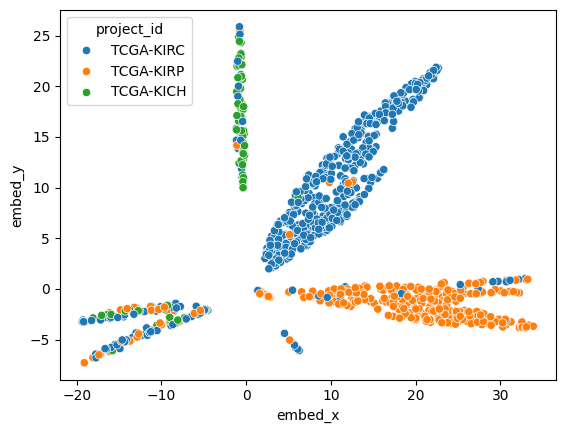

In [58]:
import seaborn as sns 
ax = sns.scatterplot(data=ge_kidney_cancer_data_embedding, x = 'embed_x', y='embed_y', hue='project_id')

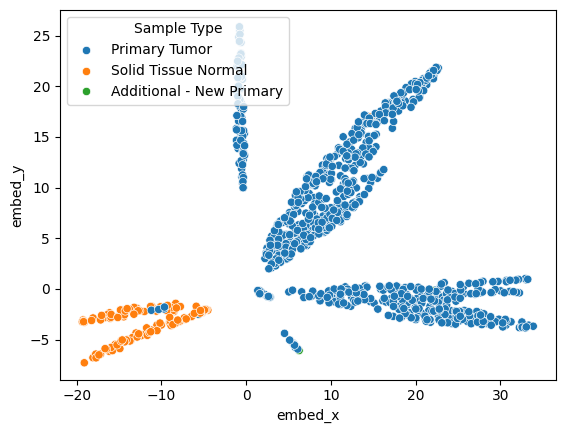

In [59]:
ax = sns.scatterplot(data=ge_kidney_cancer_data_embedding, x = 'embed_x', y='embed_y', hue='Sample Type')

## Application of gaussian mixture models

In [60]:
X = ge_kidney_cancer_data_embedding.iloc[:, :2].to_numpy()

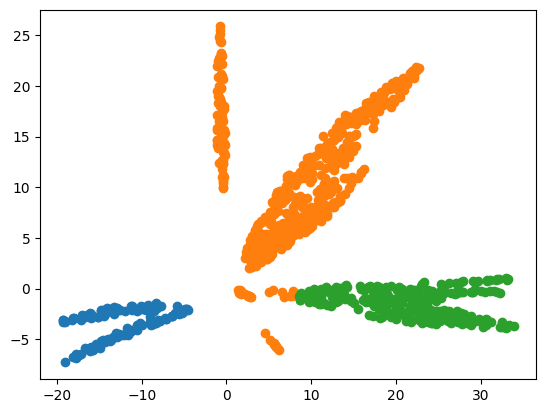

In [63]:

model = GaussianMixture(n_components=3)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

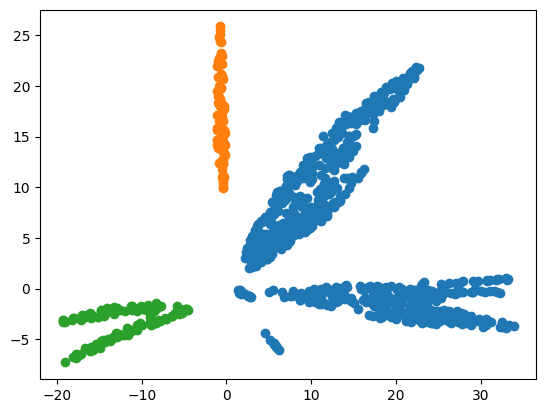

In [64]:
# spectral clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import SpectralClustering
# define the model
model = SpectralClustering(n_clusters=3)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

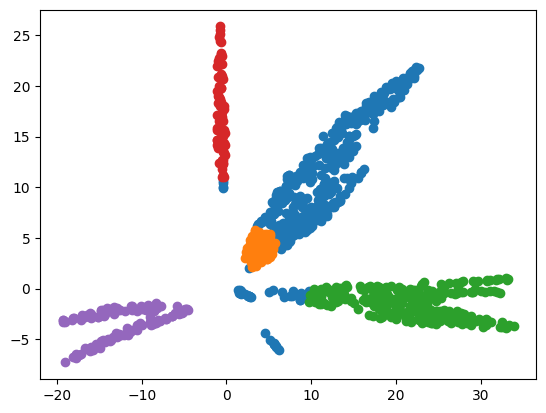

In [69]:
# optics clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import OPTICS
from matplotlib import pyplot
# define dataset

# define the model
model = OPTICS(eps=1.1, min_samples=50)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

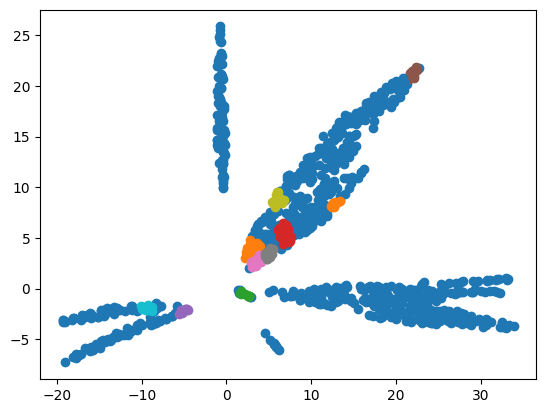

In [83]:
from sklearn.cluster import DBSCAN
# define the model
model = DBSCAN(eps=0.6, min_samples=10)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()